In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
from scipy.stats import ttest_ind
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from lifelines.statistics import logrank_test
from tqdm import tqdm
import glob
from scipy.stats import pearsonr

from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from datetime import datetime
from scipy.stats import chi2

from multiprocessing import Pool

In [2]:
#tag = "26_nov"
tag = "20_dec_21"
pheno_cols = ["ADP_pred"]

# Read phenotypes scores

In [3]:
export_folder

'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing'

In [4]:
scores_SNPs = pd.read_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder).reset_index()
scores_SNPs["index"] = scores_SNPs["index"].str.split("_",expand=True)[0].astype(int)
scores_SNPs = scores_SNPs.rename(columns={"index":"IID"})
scores_SNPs = scores_SNPs.set_index("IID")

In [5]:
SNPs = list(scores_SNPs.columns)

In [6]:
scores_SNPs

,INTERVAL_score,ADP_score,best_pval_score,best_pval_score_homogenous
IID,,,,
3988147,-0.162773,-0.157946,1.707120,0.140237
5152243,-0.172652,0.066470,2.256228,0.256766
2770265,-0.417057,-0.201585,1.126283,0.048714
3790399,-0.629205,-0.969309,0.718756,-0.088707
4681935,-0.399746,0.014031,0.543380,0.083153
...,...,...,...,...
4494916,-0.265494,-0.253767,1.924028,0.183382
4272180,-0.104392,-0.360849,0.959760,0.049855
2654475,-0.014894,-0.322015,1.140520,0.073805


# Read Sysmex Scores

In [32]:
sys_phenos = ["PLT#","MPV","PCT","PDW"]
score_dfs = []
for pheno in sys_phenos:
    dfs = []
    chrom_files = glob.glob("%s/Genetic_score_Sysmex_traits/%s_causal_score_chr*.sscore" % (export_folder,pheno))
    for i, score_file in enumerate(chrom_files):
        df = pd.read_csv(score_file,sep="\t")
        df["score"] = df["SCORE1_AVG"]
        dfs.append(df[["IID","score"]].rename(columns={"score":"score_%d" % i}))
    df = dfs[0]
    for d in dfs[1:]:
        df = pd.merge(df,d,left_on="IID",right_on="IID",how="inner")
    df = df.set_index("IID")
    score_dfs.append(pd.DataFrame(df.sum(axis=1)).rename(columns={0:pheno}))
scores_sys = pd.concat(score_dfs,axis=1)

In [33]:
scores_sys = scores_sys.rename(columns={"PLT#":"PLT"})
scores_sys = scores_sys.add_suffix("_score")
scores_sys

,PLT_score,MPV_score,PCT_score,PDW_score
IID,,,,
3988147,0.011610,-0.027600,0.007958,-0.005995
5152243,0.007862,-0.016196,0.005119,-0.002073
2770265,0.004983,-0.039424,-0.017437,-0.003341
3790399,-0.001070,-0.027039,-0.009639,0.011838
4681935,0.012693,-0.028224,0.001313,-0.005025
...,...,...,...,...
4494916,0.014897,-0.021669,0.001732,0.019635
4272180,-0.001114,-0.017683,-0.004186,0.024122
2654475,0.020629,-0.039821,-0.000400,-0.003238


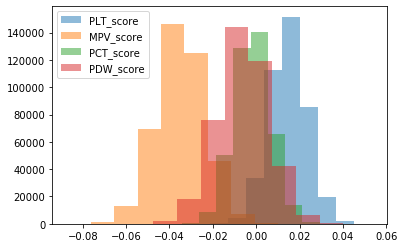

In [34]:
for c in scores_sys.columns:
    plt.hist(scores_sys[c],alpha=.5,label=c)
plt.legend()

In [35]:
scores = pd.merge(scores_SNPs, scores_sys,left_index=True,right_index=True).rename(columns={"IPF":"IPF_score"})

In [36]:
scores.head()

,INTERVAL_score,ADP_score,best_pval_score,best_pval_score_homogenous,PLT_score,MPV_score,PCT_score,PDW_score
IID,,,,,,,,
3988147,-0.162773,-0.157946,1.707120,0.140237,0.011610,-0.027600,0.007958,-0.005995
5152243,-0.172652,0.066470,2.256228,0.256766,0.007862,-0.016196,0.005119,-0.002073
2770265,-0.417057,-0.201585,1.126283,0.048714,0.004983,-0.039424,-0.017437,-0.003341
3790399,-0.629205,-0.969309,0.718756,-0.088707,-0.001070,-0.027039,-0.009639,0.011838
4681935,-0.399746,0.014031,0.543380,0.083153,0.012693,-0.028224,0.001313,-0.005025


In [37]:
# Export

scores.to_hdf("%s/scores_table.hdf" % export_folder,key="scores")

# Read UKBB outcomes

In [7]:
col_index = pd.read_csv("%s/Data_Dictionary_Showcase.tsv" % export_folder,sep="\t")
col_index.head(2)

,Path,Category,FieldID,Field,Participants,Items,Stability,ValueType,Units,ItemType,...,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82
0,UK Biobank Assessment Centre > Procedural metr...,152,3,Verbal interview duration,501635,568440,Complete,Integer,seconds,Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UK Biobank Assessment Centre > Procedural metr...,152,4,Biometrics duration,497955,568328,Complete,Integer,seconds,Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
ages = col_index.loc[col_index.Field.str.contains("Age")].set_index("FieldID")["Field"].to_dict()
ages_cols = ["%d-0.0" % a for a in ages]

In [9]:
ages

{845: 'Age completed full time education',
 2139: 'Age first had sexual intercourse',
 2217: 'Age started wearing glasses or contact lenses',
 2714: 'Age when periods started (menarche)',
 2754: 'Age at first live birth',
 2764: 'Age at last live birth',
 2794: 'Age started oral contraceptive pill',
 2804: 'Age when last used oral contraceptive pill',
 2824: 'Age at hysterectomy',
 2867: 'Age started smoking in former smokers',
 2897: 'Age stopped smoking',
 2966: 'Age high blood pressure diagnosed',
 2976: 'Age diabetes diagnosed',
 3436: 'Age started smoking in current smokers',
 3536: 'Age started hormone-replacement therapy (HRT)',
 3546: 'Age last used hormone-replacement therapy (HRT)',
 3581: 'Age at menopause (last menstrual period)',
 3627: 'Age angina diagnosed',
 3680: 'Age when last ate meat',
 3761: 'Age hay fever, rhinitis or eczema diagnosed',
 3786: 'Age asthma diagnosed',
 3872: 'Age of primiparous women at birth of child',
 3882: 'Age at bilateral oophorectomy (both o

In [11]:
ukbb_path = "/home/hv270/rds/rds-who1000-cbrc/data/UKB_13745/flat_data/ukb44092.csv"
SEX_FIELD = "31-0.0" # 0 female, 1 male
ID_FIELD = "eid"
DEATH_FIELD = '40007-0.0' # Age at death
BIRTH_FIELD = "34-0.0"
KINSHIP = '22021-0.0'
SMOKING_FIELD = "20161-0.0"
CHOLESTEROL_FIELD = "30690-0.0" 
DIABETES_FIELD = "2443-0.0"
PLT_FIELD = "30080-0.0"
MPV_FIELD = "30100-0.0"
PCT_FIELD = "30090-0.0"
PDW_FIELD = "30110-0.0"
BMI_FIELD = "21001-0.0"
CRP_FIELD = "30710-0.0"
HDL_FIELD = "30760-0.0"
SYSTOLIC_BP_FIELD = "4080-0.0"
ICD10_sec_code = ['41270-0.%d' % i for i in range(213)]
ICD10_sec_date = ['41280-0.%d' % i for i in range(213)]
genetic_PCs = ["22009-0.%d" % i for i in range(1,11)]
MEDICATION_FIELDS = ["20003-0.%d" % i for i in range(47)]
ICD10_prim_dates = col_index.loc[col_index["Field"].str.contains("Date") &\
                                 col_index["Field"].str.contains("first reported")].FieldID.astype(str).tolist()

# filter out missing ICD10_prim_dates
for chunk in pd.read_csv(ukbb_path,sep=",",chunksize=int(1e2),low_memory=False):
    ukbb_ = chunk
    ICD10_prim_dates_filtered = [c for c in ukbb_.columns if c.split("-")[0] in ICD10_prim_dates]
    break

cols = [ID_FIELD, SEX_FIELD, DEATH_FIELD, BIRTH_FIELD, 
        SMOKING_FIELD, SYSTOLIC_BP_FIELD, CHOLESTEROL_FIELD, HDL_FIELD, CRP_FIELD,
        PLT_FIELD, MPV_FIELD, PDW_FIELD, PCT_FIELD,
        BMI_FIELD, DIABETES_FIELD] + genetic_PCs + ICD10_sec_code + \
        ICD10_sec_date + ages_cols + ICD10_prim_dates_filtered + MEDICATION_FIELDS

str_cols = {}
for c in ICD10_sec_code:
    str_cols[c] = str

In [12]:
med_coding = pd.read_csv("coding4.tsv",sep="\t")

In [13]:
med_coding.head()

,coding,meaning
0,1185,vitamin e product [ctsu]
1,1187,chondroitin product
2,1189,co-enzyme q10/ubiquinone/bio-quinone/coenzyme q10
3,1191,indigestion remedy (over the counter)
4,1193,omega-3/fish oil supplement


In [14]:
all_drugs = {
    "antiplatelets":[
        "Triflusal",
        "Disgren",
        "Grendis",
        "Aflen",
        "Triflux",
        "Cangrelor",
        "Kengreal",
        "Clopidogrel",
        "Plavix",
        "Iscover",
        "Prasugrel",
        "Effient",
        "Ticagrelor",
        "Brilinta",
        "Brilique",
        "Ticlopidine",
        "Ticlid",
        "Cilostazol",
        "Pletal",
        "Vorapaxar",
        "Zontivity",
        "Abciximab",
        "ReoPro",
        "Eptifibatide",
        "Integrilin",
        "Tirofiban",
        "Aggrastat",
        "Dipyridamole",
        "Persantine",
        "Terutroban"
    ],
    "anticoagulants":[
        "Apixaban",
        "Eliquis",
        "Betrixaban",
        "Bevyxxa",
        "Dabigatran",
        "Pradaxa",
        "Pradax",
        "Prazaxa",
        "Edoxaban",
        "Savaysa",
        "Lixiana",
        "Roteas",
        "Enoxaparin",
        "Lovenox",
        "Clexane",
        "Xaparin",
        "Fondaparinux",
        "Arixtra",
        "Heparin",
        "Prothrombin",
        "Kcentra",
        "Rivaroxaban",
        "Xarelto",
        "Warfarin",
        "Coumadin",
        "Jantoven"],
}

In [15]:
med_coding.meaning.str.lower()

0                                vitamin e product [ctsu]
1                                     chondroitin product
2       co-enzyme q10/ubiquinone/bio-quinone/coenzyme q10
3                   indigestion remedy (over the counter)
4                             omega-3/fish oil supplement
                              ...                        
6740                                        cyclosporin a
6741                                       phenobarbitone
6742                                            phenytoin
6743                                          paracetamol
6744                                  aluminium hydroxide
Name: meaning, Length: 6745, dtype: object

In [16]:
drug_codes = {}
for drug_type, drugs in all_drugs.items():
    for drug in drugs:
        if med_coding.meaning.str.lower().str.contains(drug.lower()).sum() > 0:
            drug_codes[drug] = med_coding.loc[med_coding.meaning.str.lower().str.contains(drug.lower()),"coding"].tolist()
            print("%s : %s" % (drug, med_coding.loc[med_coding.meaning.str.lower().str.contains(drug.lower()),"meaning"].tolist()))

Clopidogrel : ['clopidogrel']
Plavix : ['plavix 75mg tablet']
Ticlopidine : ['ticlopidine']
Ticlid : ['ticlid 250mg tablet']
Cilostazol : ['cilostazol']
Pletal : ['pletal 100mg tablet']
Dipyridamole : ['dipyridamole', 'dipyridamole+aspirin']
Enoxaparin : ['enoxaparin']
Clexane : ['clexane 20mg/0.2ml prefilled syringe']
Xaparin : ['enoxaparin']
Heparin : ['subcutaneous heparin', 'heparinoid+salicylic acid 0.2%/2% cream', 'heparinoid+salicylic acid 0.2%/2% gel', 'heparin']
Warfarin : ['warfarin', 'sodium warfarin']


In [17]:
drug_codes

{'Clopidogrel': [1141168318],
 'Plavix': [1141168322],
 'Ticlopidine': [1141163324],
 'Ticlid': [1141163328],
 'Cilostazol': [1141181150],
 'Pletal': [1141181154],
 'Dipyridamole': [1140861778, 1141167844],
 'Enoxaparin': [1140861588],
 'Clexane': [1140861594],
 'Xaparin': [1140861588],
 'Heparin': [1140864956, 1140877958, 1140877960, 1140881842],
 'Warfarin': [1140888266, 1140910832]}

In [18]:
# Read full table
ukbb_ = pd.read_csv(ukbb_path,sep=",",usecols=cols, low_memory=True, 
                    dtype=str_cols,
                    parse_dates=ICD10_sec_date + [BIRTH_FIELD,DEATH_FIELD] + ICD10_prim_dates_filtered);
ukbb_.set_index(ID_FIELD,inplace=True)

In [19]:
rel = pd.read_csv("/home/hv270/rds/rds-wja24-uk-biobank-gen/rel/ukb13745_rel_s488339.dat",sep=" ")
related_people = rel.loc[rel.Kinship < 0.0612].ID2.unique().tolist()

european_individuals = pd.read_csv("/rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/blood_trait_gwas_2020_contributing_ids.tsv",header=None)
european_individuals = european_individuals.rename(columns={0:"FID"})
EUR_IDs = european_individuals.FID.tolist()

to_keep = ukbb_.index.isin(EUR_IDs) & ~ukbb_.index.isin(related_people)
print("%d people kept over %d" %(to_keep.sum(),ukbb_.shape[0]))

UKB = ukbb_.loc[to_keep]
UKB = UKB.loc[~UKB[BIRTH_FIELD].isnull()]
UKB = UKB.loc[~UKB[SEX_FIELD].isnull()]

384059 people kept over 502493


In [20]:
UKB["drug_codes"] = UKB[MEDICATION_FIELDS].astype(str).agg(",".join,axis=1)
for drug, codes in drug_codes.items():
    UKB[drug] = False
    for code in codes:
        UKB[drug] = UKB[drug] | UKB["drug_codes"].str.contains(str(code))
    print("%s : %d" % (drug, UKB[drug].sum()))
    if UKB[drug].sum() == 0:
        del UKB[drug]

Clopidogrel : 2416
Plavix : 179
Ticlopidine : 1
Ticlid : 0
Cilostazol : 28
Pletal : 5
Dipyridamole : 702
Enoxaparin : 12
Clexane : 18
Xaparin : 12
Heparin : 25
Warfarin : 4023


In [21]:
for drug_type, drugs in all_drugs.items():
    col_name = "field_20003_%s" % drug_type
    UKB[col_name] = False
    for d in drugs:
        if d in UKB.columns:
            UKB[col_name] = UKB[col_name] | UKB[d]
    print("%s : %d" % (drug_type,UKB[col_name].sum()))

antiplatelets : 3303
anticoagulants : 4074


In [22]:
drugs_ET_1 = pd.read_csv("/rds/project/who1000-1/rds-who1000-cbrc/user/et341/tmp/prescription-data1.txt",sep="\t",header=None)
drugs_ET_2 = pd.read_csv("/rds/project/who1000-1/rds-who1000-cbrc/user/et341/tmp/prescription-data2.txt",sep="\t",header=None)
drugs_ET = pd.concat([drugs_ET_1,drugs_ET_2]).rename(columns={0:"ID",1:"date",2:"drug"})
drugs_ET["date"] = pd.to_datetime(drugs_ET["date"],dayfirst=True)
valid_date = drugs_ET.date < pd.to_datetime("2019-01-01")
drugs_ET = drugs_ET.loc[valid_date]
drugs_ET = drugs_ET.pivot_table(values="date",columns="drug",index="ID",aggfunc="min")

In [23]:
drugs_ET.isnull().sum(axis=0).sort_values(ascending=True).index[-50:]

Index(['Dipyridamole & Aspirin 200 mg + 25 mg modified release capsu',
       'Dipyridamole  Tablets  25 mg', 'Dipyridamole  M/R Capsules  200 mg',
       'Dabigatran Etexilate  Capsules  75 mg',
       'DIPYRIDAMOLE modified release capsule 200mg',
       'DIPYRIDAMOLE RETARD TABLETS 200MG', 'DIPYRIDAMOLE RETARD 200MG CAPS',
       'DABIGATRAN ETEXILATE 75mg capsules', 'Clopidogrel Tablets 75 mg',
       'Clopidogrel TABS 300MG', 'Clopidogrel 75mg/5ml oral suspension',
       'Clopidogrel 75mg/5ml oral solution',
       'Clopidogrel 75mg tablets (Dexcel-Pharma Ltd)',
       'Clopidogrel 75mg tablets (Aspire Pharma Ltd)',
       'Clopidogrel  Tablets  300 mg', 'CLOPIDOGREL FC tab 300mg',
       'CLOPIDOGREL 75MG TABS', 'CLOPIDOGREL 75MG TABLET', 'WARFARIN',
       'WARFARIN 1MG', 'WARFARIN 3MG TABLETS', 'WARFARIN 3mg tablets',
       'Warfarin 3mg Tablet (WB Pharmaceuticals Ltd)',
       'Warfarin 1mg/ml oral suspension sugar free',
       'Warfarin 1mg tablets (Sandoz Ltd)',
       'W

In [24]:
drugs_ET.shape

(22822, 228)

In [25]:
(~drugs_ET.isnull()).sum().sum()

43391

In [26]:
drugs_ET["Warfarin (any)"] =  drugs_ET[[c for c in drugs_ET.columns if "warfa" in c.lower()]].min(axis=1)
drugs_ET["Apixaban (any)"] =  drugs_ET[[c for c in drugs_ET.columns if "apixa" in c.lower()]].min(axis=1)
drugs_ET["Clopidogrel (any)"] =  drugs_ET[[c for c in drugs_ET.columns if "clopidogrel" in c.lower()]].min(axis=1)
drugs_ET["Rivaroxaban (any)"] =  drugs_ET[[c for c in drugs_ET.columns if "rivaro" in c.lower()]].min(axis=1)
drugs_ET["Dipyridamole (any)"] =  drugs_ET[[c for c in drugs_ET.columns if "ipyridamole" in c.lower()]].min(axis=1)
drugs_ET["Ticagrelor (any)"] =  drugs_ET[[c for c in drugs_ET.columns if "icagrelor" in c.lower()]].min(axis=1)
drugs_ET["Prasugrel (any)"] =  drugs_ET[[c for c in drugs_ET.columns if "asugrel" in c.lower()]].min(axis=1)
drugs_ET["Dabigatran (any)"] =  drugs_ET[[c for c in drugs_ET.columns if "dabigatran" in c.lower()]].min(axis=1)
drugs_ET["All drugs (any)"] =  drugs_ET.min(axis=1)

In [27]:
for c in drugs_ET.columns:
    if "(any)" in c:
        print(c, (~drugs_ET[c].isnull()).sum())

Warfarin (any) 9279
Apixaban (any) 1247
Clopidogrel (any) 11542
Rivaroxaban (any) 1786
Dipyridamole (any) 1742
Ticagrelor (any) 767
Prasugrel (any) 297
Dabigatran (any) 291
All drugs (any) 22822


In [28]:
drugs_mapping = {}
#drugs_mapping_inv = {}
for i, c in enumerate(drugs_ET.columns):
    drugs_mapping[c] = "DRUG_%d" % i
#    drugs_mapping_inv[i] = c

In [29]:
drug_columns = pd.DataFrame.from_dict(drugs_mapping,orient="index").reset_index().rename(columns={"index":"drug",0:"drug_ID"})

In [30]:
drug_columns.tail()

,drug,drug_ID
232,Dipyridamole (any),DRUG_232
233,Ticagrelor (any),DRUG_233
234,Prasugrel (any),DRUG_234
235,Dabigatran (any),DRUG_235
236,All drugs (any),DRUG_236


In [31]:
drug_columns.to_csv("%s/drug_columns.hdf" % export_folder)

In [32]:
cols = list(UKB.columns)
for c in cols:
    if "DRUG" in c:
        del UKB[c]

In [33]:
UKB = pd.merge(UKB,drugs_ET.rename(columns=drugs_mapping),left_index=True,right_index=True,how="left")

In [34]:
UKB["AGE"] = (pd.to_datetime("01-01-2019") - UKB[BIRTH_FIELD]).dt.days // 365
is_dead = ~UKB[DEATH_FIELD].isnull()
UKB.loc[is_dead,"AGE"] = UKB.loc[is_dead,DEATH_FIELD].astype(float)
UKB.to_hdf("%s/UKB.hdf" % export_folder,key="UKB")

/home/hv270/.local/lib/python3.7/site-packages/pandas/core/generic.py:2620: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['40007-0.0', '41270-0.0', '41270-0.1', '41270-0.2', '41270-0.3',
       '41270-0.4', '41270-0.5', '41270-0.6', '41270-0.7', '41270-0.8',
       ...
       '41270-0.204', '41270-0.205', '41270-0.206', '41270-0.207',
       '41270-0.208', '41270-0.209', '41270-0.210', '41270-0.211',
       '41270-0.212', 'drug_codes'],
      dtype='object', length=215)]

  encoding=encoding,
